# Exploring latent spaces of VAEs trained to reconstruct SIAM spectral functions

### Import packages we need, and set plotting styles

In [1]:
import sys
import pickle

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.figsize'] = (14, 10)

sys.path.append('..')
import specvae
from specvae.data_util.data_util import prepare_autoencoder_data
from specvae.protocols.autoencoder_protocol import AutoencoderTrainProtocol

%matplotlib inline
# Replace the above line with this for rotatable 3D plots below, if this works for you.
# %matplotlib notebook

params = {
    'font.family': 'CMU Sans Serif',
    'axes.titlesize': 20,
    'axes.labelsize': 36,
    'axes.linewidth': 2,
    'axes.labelpad': 10,
    'xtick.labelsize': 32,
    'ytick.labelsize': 32,
    'xtick.minor.width': 1,
    'xtick.minor.size': 5,
    'xtick.major.width': 2,
    'xtick.major.size': 10,
    'ytick.major.width': 2,
    'ytick.major.size': 10,
    'xtick.direction': 'in',
    'ytick.minor.width': 1,
    'ytick.minor.size': 5,
    'ytick.direction': 'in',
    'font.weight': 'normal',
    'axes.unicode_minus': False,
    'legend.fontsize': 36,
    'mathtext.fontset': 'cm',
    'svg.fonttype': 'path',
}

plt.rcParams.update(params)

### Function which grabs latent means from passing data through a model

In [2]:
def extract_latents(model, targets):
    n_latents = model.latent_space_size
    with torch.no_grad():
        encoder = model.encoder
        
        # WARNING: Computing all latents in one pass is faster, but uses a large amount
        #            of memory. If this is a problem, comment this line out and uncomment
        #            the ones below.
        latents = encoder(torch.tensor(targets).float())[:, :n_latents]
        #  latents = [encoder(torch.tensor(np.expand_dims(x, axis=0)).float())[:, :n_latents] for x in targets]
        #  latents = torch.cat(latents, dim=0)
    return latents

# Exploring latent space of a VAE trained on low-$B$, low-$T$ data

### First, load the data and index out the low-$B$, low-$T$ dataset

In [3]:
f = pd.read_csv("../data/trials_features_log_scaled.csv")
m = pd.read_csv("../data/trials_meta.csv")
t = pd.read_csv("../data/trials_targets.csv")
f_noscale = pd.read_csv("../data/trials_features.csv")

In [4]:
lowB_indices = pickle.load(open('../data/indices/lowBlowT_indices.pkl', 'rb'))
GLOBAL_features = np.array(f)[lowB_indices['train'], :]                   # Hamiltonian/System parameters
GLOBAL_metadata = np.array(m)[lowB_indices['train'], :]                   # Kondo Temp / Normalization
GLOBAL_targets = np.array(t)[lowB_indices['train'], :]                    # Spectral functions
GLOBAL_features_no_scale = np.array(f_noscale)[lowB_indices['train'], :]  # Unscaled system parameters

# Unpack all of the system parameters
U = GLOBAL_features[:, 0]
Γ = GLOBAL_features_no_scale[:, 1]
ϵ = GLOBAL_features[:, 2]
B_scaled = GLOBAL_features[:, 3]
T_scaled = GLOBAL_features[:, 4]
B = GLOBAL_features_no_scale[:, 3]
T = GLOBAL_features_no_scale[:, 4]
TK = GLOBAL_metadata[:, 0]
TK_scaled = np.log10(TK)
SPE = np.maximum(np.maximum(np.abs(B), T), TK)
SPE_scaled = np.log10(SPE)

### Load our trained model

In [5]:
state_dict = torch.load('../models/pretrained/lowBlowT_2active.pt', map_location='cpu')
lowB_model = specvae.models.autoencoder.VariationalAutoencoder(333, [240, 160, 80, 60], 10)
lowB_model.load_state_dict(state_dict)

### We can measure KL losses to identify active neurons

In [6]:
recon_loss = np.zeros(GLOBAL_targets.shape[0])
with torch.no_grad():
    output, mu, log_var = lowB_model(torch.tensor(GLOBAL_targets).to(torch.float32))
    kl_losses = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
    kl_losses = torch.sum(kl_losses, dim=0)
kl_losses

tensor([1.3245e-02, 5.6181e+04, 6.4657e+00, 1.4001e-02, 1.5303e-02, 4.9552e+04,
        7.3917e-02, 1.0316e-02, 1.6020e-02, 9.7087e-03])

### From this, we can see that neurons 1 and 5 are the only "active" ones, since their KL loss is greater than all of the others by at least a factor of $10^4$. Let's select these out and see how they behave across the dataset.

In [7]:
latent_features = extract_latents(lowB_model, GLOBAL_targets)
active1 = latent_features[:, 1]
active2 = -latent_features[:, 5]  # Taking the negative is visually nice, but not necessary

## Plot all spectral functions in the latent space of neurons 1 and 5, colored by $\log_{10} T_K$ and $(U + 2\epsilon_d)/\Gamma$

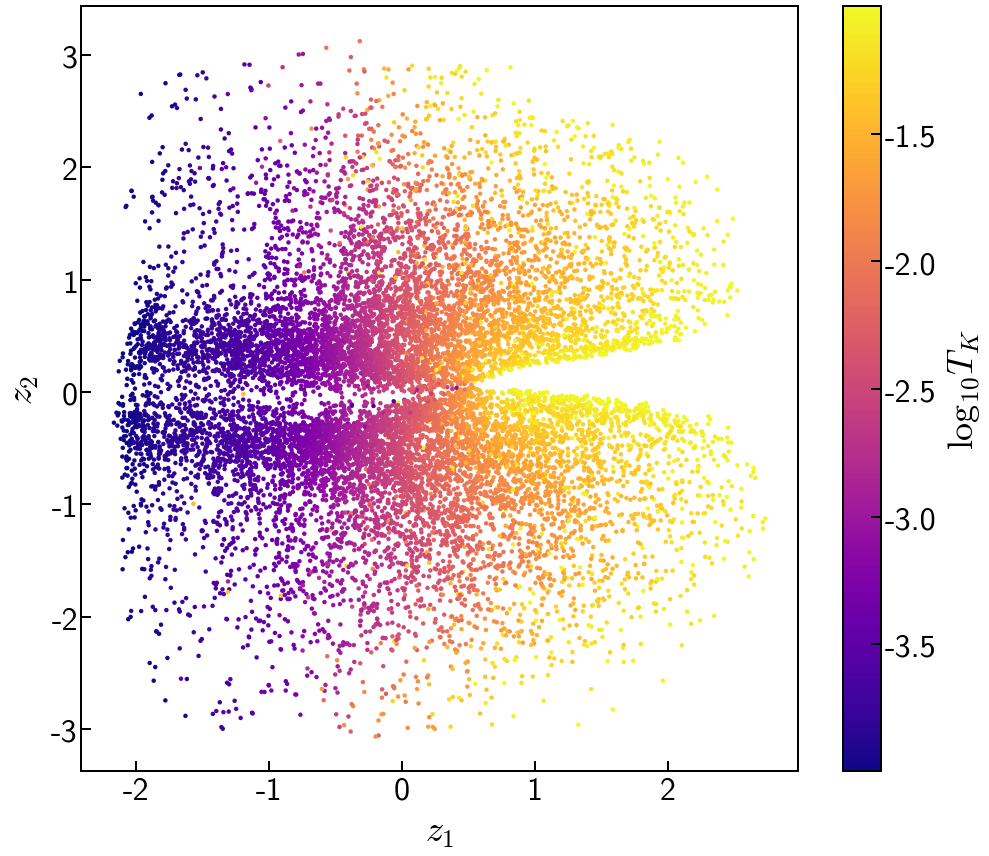

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_2d_latents(latent1, latent2, feat, feat_label, **kwargs):
    plt.close()
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111)

    ax.xaxis.set_tick_params(width=2, length=10)
    ax.yaxis.set_tick_params(width=2, length=10)
    scat = plt.scatter(latent1, latent2, c=feat, **kwargs)
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    plt.colorbar(label=feat_label)
    plt.tight_layout()
    plt.show()

# Plot every other point just to reduce density of points in the plot
plot_2d_latents(active1[::2], active2[::2], TK_scaled[::2], r"$\log_{10} T_K$",
                cmap='plasma', s=20, alpha=1.0, linewidths=0, rasterized=True)

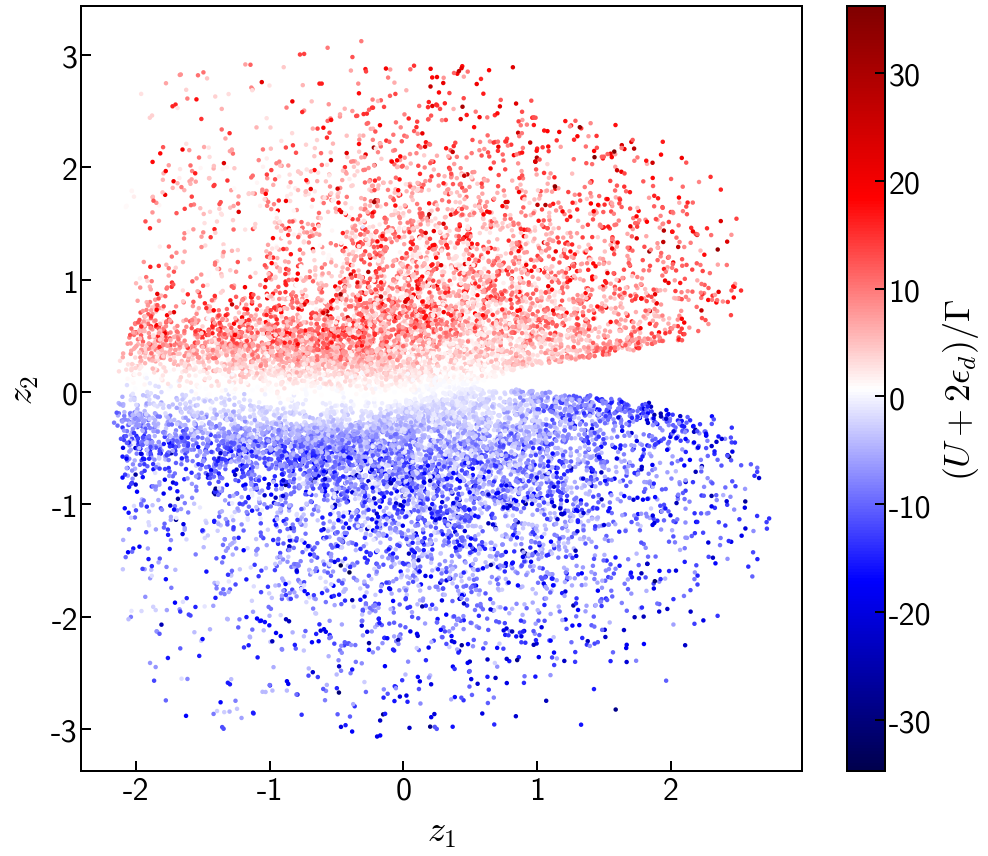

In [9]:
plot_2d_latents(active1[::2], active2[::2], (U[::2] + 2 * ϵ[::2]) / Γ[::2], r"$(U + 2\epsilon_d)/\Gamma$",
                cmap='seismic', s=20, alpha=1.0, linewidths=0, rasterized=True)

## Plot a grid of spectral functions obtained by varying the two "active" neurons

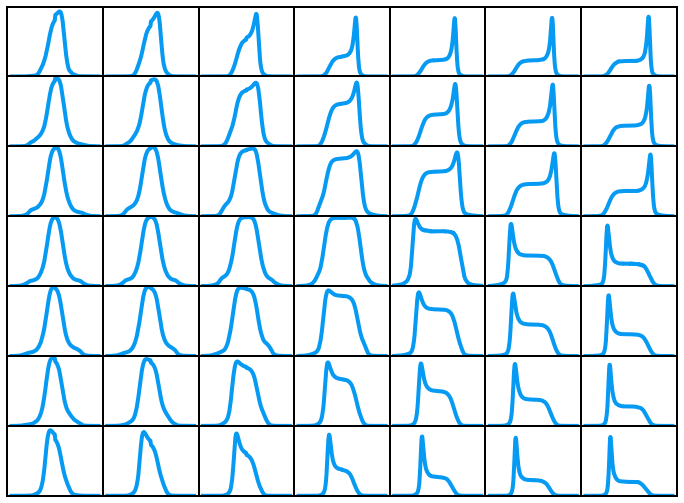

In [10]:
encoder, decoder = lowB_model.encoder, lowB_model.decoder
gridsize = 7
n_latents = 10

fig, axs = plt.subplots(gridsize, gridsize, gridspec_kw={'wspace': 0.0, 'hspace': 0.0}, figsize=(12, 9))

# The two "active" neurons
neur1, neur2 = 1, 5
latent_pt = torch.zeros(1, n_latents)
with torch.no_grad():
    for i, n1 in enumerate(np.linspace(-2, 2, num=gridsize)):
        for j, n2 in enumerate(np.linspace(2, -2, num=gridsize)):
            latent_pt[0, neur1] = n1
            latent_pt[0, neur2] = -n2  # Negative, just to match visually with scatterplot

            curve = torch.nn.functional.softplus(decoder(latent_pt))[0].numpy()
            axs[j, i].plot(curve, lw=4, color="xkcd:azure")
            axs[j, i].tick_params(bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
            axs[j, i].set_ylim(0, 1)

# Symbolic Regression - low-$B$, low-$T$ model

In the cells below, we are going to try and find symbolic expressions which maximally correlate with each of the latents of the model trained on the low-$B$, low-$T$ dataset.

I.e., we are going to try to find symbolic functions $f_1(U, \Gamma, \epsilon), f_2(U, \Gamma, \epsilon)$ with some space of functions $\mathcal{S}$ such that:

$$ f_i = \arg \max_{f \in \mathcal{S}} \frac{\left(f(U, \Gamma, \epsilon) - \langle f \rangle\right)\left(z_i(U, \Gamma, \epsilon) - \langle z_i \rangle\right)}{\sigma_{f}\sigma_{z_i}} $$


## Regressing $f_1$

In [11]:
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
from gplearn.functions import make_function
from gplearn.fitness import make_fitness, _weighted_pearson

symb = SymbolicTransformer(
    population_size=5000, tournament_size=200,
    generations=20, n_components=1,
    verbose=1,
    parsimony_coefficient=0.01,    # Penalization for each node in the syntax tree
    random_state=44444,
    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg',),
    n_jobs=4, warm_start=False, feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
    metric='pearson', low_memory=True, const_range=(0.0, 3.0),
)

# To do protected divisions, clip value of denominator to 1e-6
U[U == 0] = 1e-6

X_train = np.stack([U / Γ, ϵ / U, ϵ / Γ], axis=1)
symb.fit(X_train, active1)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.03        0.0931158       40         0.786244              N/A      1.16m
   1     8.02         0.316161       15         0.789296              N/A      1.04m
   2     5.08         0.436256        5         0.765159              N/A     57.25s
   3     4.96          0.44696        5         0.765159              N/A     50.65s
   4     5.02         0.442867        5         0.765159              N/A     49.12s
   5     4.96          0.45215        5         0.765159              N/A     47.40s
   6     5.01         0.448316        5         0.765159              N/A     43.99s
   7     4.99         0.447948        5         0.765159              N/A     40.59s
   8     5.00         0.453078        5         0.765159              N/A  

SymbolicTransformer(const_range=(0.0, 3.0), feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
                    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg'),
                    low_memory=True, n_components=1, n_jobs=4,
                    parsimony_coefficient=0.01, population_size=5000,
                    random_state=44444, tournament_size=200, verbose=1)

### Some metrics on how the regression progressed:

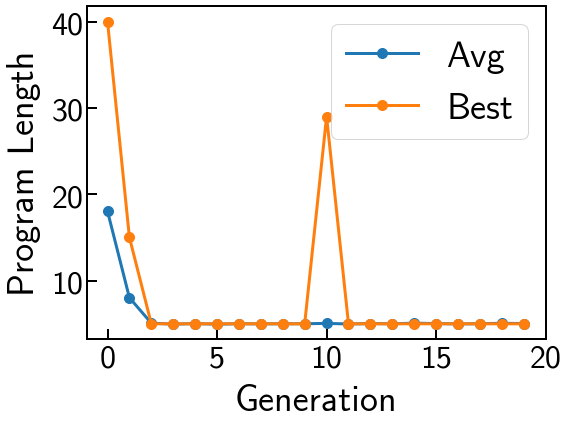

In [12]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.plot(symb.run_details_['generation'], symb.run_details_['average_length'], 'o-', lw=3, ms=10, label="Avg")
plt.plot(symb.run_details_['generation'], symb.run_details_['best_length'], 'o-', lw=3, ms=10, label="Best")
plt.xlabel("Generation")
plt.ylabel("Program Length")
plt.xticks(np.arange(0, 21, step=5))

plt.legend()
plt.tight_layout()
plt.show()

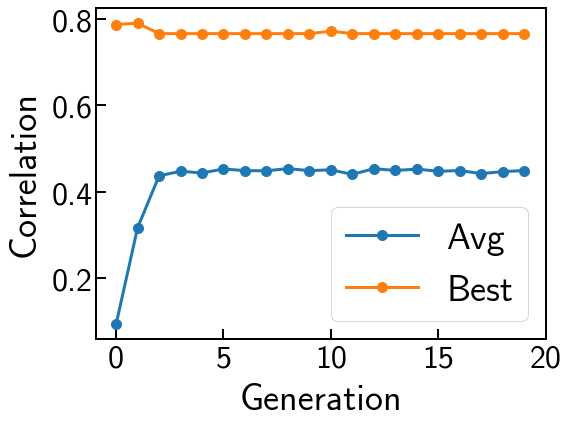

In [13]:
plt.close('all')
plt.figure(figsize=(8, 6))
plt.plot(symb.run_details_['generation'], symb.run_details_['average_fitness'], 'o-', lw=3, ms=10, label="Avg")
plt.plot(symb.run_details_['generation'], symb.run_details_['best_fitness'], 'o-', lw=3, ms=10, label="Best")
plt.xlabel("Generation")
plt.ylabel("Correlation")
plt.xticks(np.arange(0, 21, step=5))

plt.legend()
plt.tight_layout()
plt.show()

## Let's look at the final function $f_1$ we learned

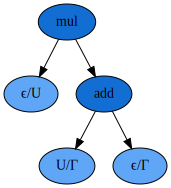

In [14]:
import graphviz
graphviz.Source(symb._best_programs[0].export_graphviz())

#### De-syntax-tree'd, this is:

$$ f_1 = \frac{\epsilon(\epsilon + U)}{U\Gamma} $$

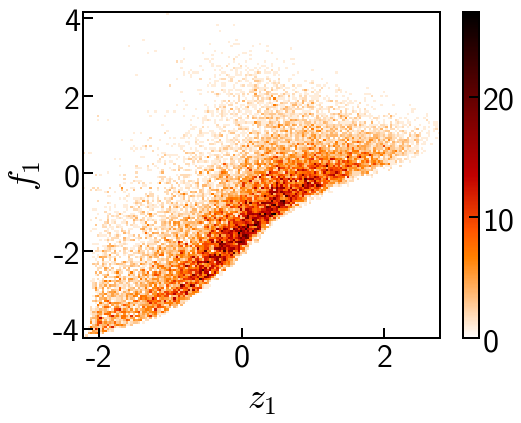

In [15]:
plt.close()
plt.figure(figsize=(8, 6))
plt.hist2d(active1.numpy(), ϵ * (ϵ + U) / (U * Γ), bins=150, cmap='gist_heat_r', rasterized=True)
plt.ylabel(r"$f_1$")
plt.xlabel(r"$z_1$")
plt.colorbar()
plt.show()

### This is remarkably close to the $\log$ of the Kondo temperature $T_K$! The full equation is:

$$T_K = \sqrt{\frac{U\Gamma}{2}} \exp\left(\frac{\pi \epsilon(\epsilon + U)}{2U\Gamma}\right)$$

### So, this misses the term coming from $\sqrt{U\Gamma/2}$ as well as an overall coefficient/constant.

## Let's now do the same for $z_2$:

In [16]:
symb = SymbolicTransformer(
    population_size=5000, tournament_size=200,
    generations=20, n_components=1,
    verbose=1,
    parsimony_coefficient=0.01,    # Penalization for each node in the syntax tree
    random_state=44444,
    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg',),
    n_jobs=4, warm_start=False, feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
    metric='pearson', low_memory=True, const_range=(0.0, 3.0),
)

X_train = np.stack([U / Γ, ϵ / U, ϵ / Γ], axis=1)
symb.fit(X_train, active2)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.03          0.15557        7         0.867229              N/A     55.98s
   1     4.85          0.51213       10         0.879367              N/A      1.00m
   2     6.65         0.362774        9         0.888535              N/A      1.12m
   3     4.98         0.442267        7         0.866859              N/A      1.00m
   4     5.02         0.450841        5          0.86872              N/A     55.54s
   5     4.95          0.45693        5          0.86872              N/A     52.13s
   6     5.01         0.449758        5          0.86872              N/A     52.80s
   7     4.99         0.458085        5          0.86872              N/A     45.52s
   8     5.00          0.45636        5          0.86872              N/A  

SymbolicTransformer(const_range=(0.0, 3.0), feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
                    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg'),
                    low_memory=True, n_components=1, n_jobs=4,
                    parsimony_coefficient=0.01, population_size=5000,
                    random_state=44444, tournament_size=200, verbose=1)

## Final function $f_2$ we learned

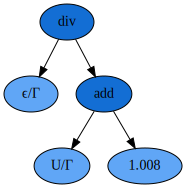

In [17]:
graphviz.Source(symb._best_programs[0].export_graphviz())

### This is (rounding $1.008$ to $1$) :

$$f_2 = \epsilon / (U + \Gamma)$$

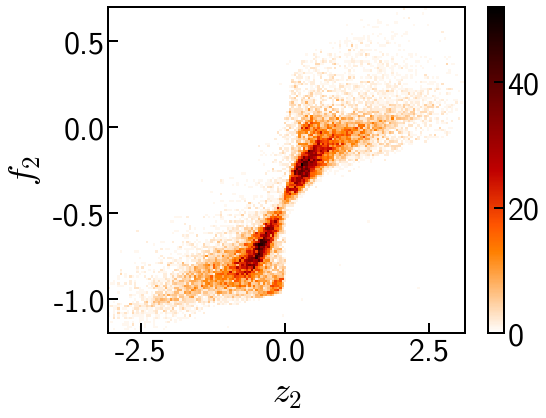

In [18]:
plt.close()
plt.figure(figsize=(8, 6))
plt.hist2d(active2.numpy(), ϵ / (U + Γ), vmax=52, bins=150, cmap='gist_heat_r', rasterized=True)
plt.ylabel(r"$f_2$")
plt.xlabel(r"$z_2$")
plt.ylim(-1.2, 0.7)
plt.colorbar()
plt.show()

### This is not quite the particle-hole asymmetry. However, it might be that outliers at large $z_2$ are driving the regression to an incorrect function. What if we regress only on points close to $z_2 = 0$?

In [19]:
symb = SymbolicTransformer(
    population_size=5000, tournament_size=200,
    generations=20, n_components=1,
    verbose=1,
    parsimony_coefficient=0.01,    # Penalization for each node in the syntax tree
    random_state=44444,
    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg',),
    n_jobs=4, warm_start=False, feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
    metric='pearson', low_memory=True, const_range=(0.0, 3.0),
)

# Collect all the points where |z2| < 0.5
good_pts = np.less(np.abs(active2.numpy()), 0.5).astype(np.bool)
X_train = np.stack([U / Γ, ϵ / U, ϵ / Γ], axis=1)
symb.fit(X_train[good_pts, :], active2[good_pts])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    18.03         0.148148        6         0.851615              N/A     33.02s
   1     6.36         0.488337       10         0.863836              N/A     50.73s
   2     5.91         0.514661       10         0.861167              N/A     50.67s
   3     4.97         0.754105        5         0.851615              N/A     53.50s
   4     5.06         0.759046        5         0.851615              N/A     48.69s
   5     4.96         0.754567        5         0.851615              N/A     46.00s
   6     5.00         0.757458        5         0.851615              N/A     41.57s
   7     4.99         0.754638        5         0.851615              N/A     39.83s
   8     4.99         0.756212        5         0.851615              N/A  

SymbolicTransformer(const_range=(0.0, 3.0), feature_names=['U/Γ', 'ϵ/U', 'ϵ/Γ'],
                    function_set=('add', 'mul', 'div', 'sub', 'inv', 'neg'),
                    low_memory=True, n_components=1, n_jobs=4,
                    parsimony_coefficient=0.01, population_size=5000,
                    random_state=44444, tournament_size=200, verbose=1)

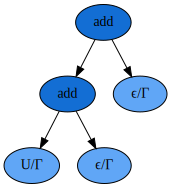

In [20]:
graphviz.Source(symb._best_programs[0].export_graphviz())

### This is: $(U + 2\epsilon_d)/\Gamma$

### Now, the regression picks out the correct function!

# Exploring latent space of a VAE trained on full-parameter data

### Index out the full-parameter dataset

In [21]:
fullp_indices = pickle.load(open('../data/indices/random_60k_indices.pkl', 'rb'))
GLOBAL_features = np.array(f)[fullp_indices['train'], :]                   # Hamiltonian/System parameters
GLOBAL_metadata = np.array(m)[fullp_indices['train'], :]                   # Kondo Temp / Normalization
GLOBAL_targets = np.array(t)[fullp_indices['train'], :]                    # Spectral functions
GLOBAL_features_no_scale = np.array(f_noscale)[fullp_indices['train'], :]  # Unscaled system parameters

# Unpack all of the system parameters
U = GLOBAL_features[:, 0]
Γ = GLOBAL_features_no_scale[:, 1]
ϵ = GLOBAL_features[:, 2]
B_scaled = GLOBAL_features[:, 3]
T_scaled = GLOBAL_features[:, 4]
B = GLOBAL_features_no_scale[:, 3]
T = GLOBAL_features_no_scale[:, 4]
TK = GLOBAL_metadata[:, 0]
TK_scaled = np.log10(TK)
SPE = np.maximum(np.maximum(np.abs(B), T), TK)
SPE_scaled = np.log10(SPE)

<ipython-input-21-118149b30556>:16: RuntimeWarning: divide by zero encountered in log10
  TK_scaled = np.log10(TK)


### Load our trained model

In [22]:
state_dict = torch.load('../models/pretrained/fullparam_3active.pt', map_location='cpu')
full_model = specvae.models.autoencoder.VariationalAutoencoder(333, [240, 160, 80, 60], 10)
full_model.load_state_dict(state_dict)

### We can measure KL losses to identify active neurons

In [23]:
recon_loss = np.zeros(GLOBAL_targets.shape[0])
with torch.no_grad():
    output, mu, log_var = full_model(torch.tensor(GLOBAL_targets).to(torch.float32))
    kl_losses = -0.5 * (1 + log_var - mu.pow(2) - log_var.exp())
    kl_losses = torch.sum(kl_losses, dim=0)
kl_losses

tensor([3.8231e-02, 6.2930e+04, 3.0317e-02, 1.8888e-02, 1.8189e-02, 6.0889e-03,
        1.1836e+05, 4.6409e+04, 1.4459e-02, 6.3558e-02])

### From this, we can see that neurons 2, 7, and 8 (one-indexed) are the only "active" ones. Let's select these out and see how they behave across the dataset.

In [24]:
latent_features = extract_latents(full_model, GLOBAL_targets)
active1 = latent_features[:, 6]
active2 = -latent_features[:, 7]  # Taking the negative is visually nice, but not necessary
active3 = latent_features[:, 1]

## Plot all curves in the latent space of neurons 1, 6, and 7, colored by various features

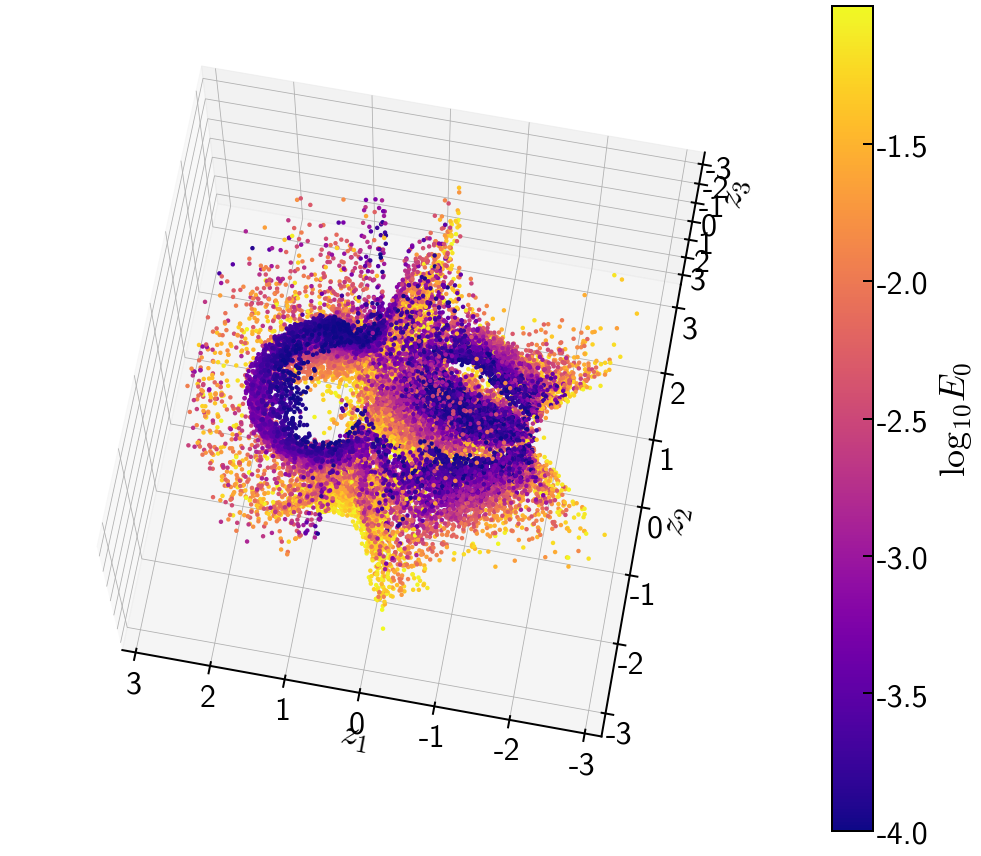

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Nice view angles
nice_azim, nice_elev = 79.48272801616224, -108.3187308506522

def plot_3d_latents(latent1, latent2, latent3, feat, feat_label, **kwargs):
    plt.close()
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    ax.xaxis.set_tick_params(width=2, length=10)
    ax.yaxis.set_tick_params(width=2, length=10)
    ax.zaxis.set_tick_params(width=2, length=10)
    scat = plt.scatter(latent1, latent2, zs=latent3, c=feat, **kwargs)
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_zlabel(r"$z_3$")
    ax.view_init(nice_elev, nice_azim)
    plt.colorbar(label=feat_label)
    plt.tight_layout()
    plt.show()

# Plot every other point just to reduce density of points in the plot
plot_3d_latents(active1[::2], active2[::2], active3[::2], SPE_scaled[::2], r"$\log_{10} E_0$",
                cmap='plasma', s=20, alpha=1.0, linewidths=0)

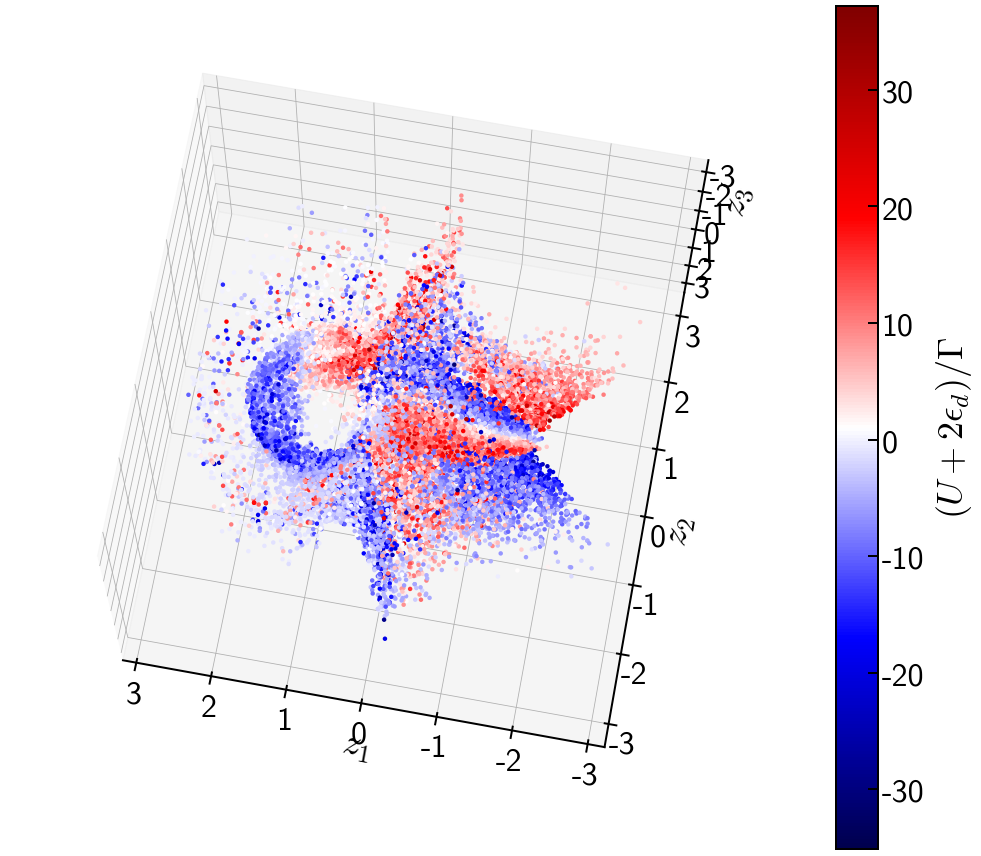

In [26]:
plot_3d_latents(active1[::2], active2[::2], active3[::2], (U[::2] + 2 * ϵ[::2]) / Γ[::2],
                r"$(U + 2\epsilon_d)/\Gamma$", cmap='seismic', s=20, alpha=1.0, linewidths=0)

### "What energy dominates where" colormap: Requires a lot of ugly fussing with colormaps.

<ipython-input-27-a85725fe1d1d>:9: RuntimeWarning: divide by zero encountered in true_divide
  T_dom = np.minimum(T / np.abs(B), T / TK)
<ipython-input-27-a85725fe1d1d>:10: RuntimeWarning: divide by zero encountered in true_divide
  TK_dom = np.minimum(TK / np.abs(B), TK / T)
<ipython-input-27-a85725fe1d1d>:11: RuntimeWarning: divide by zero encountered in true_divide
  B_dom = np.minimum(np.abs(B) / T, np.abs(B) / TK)


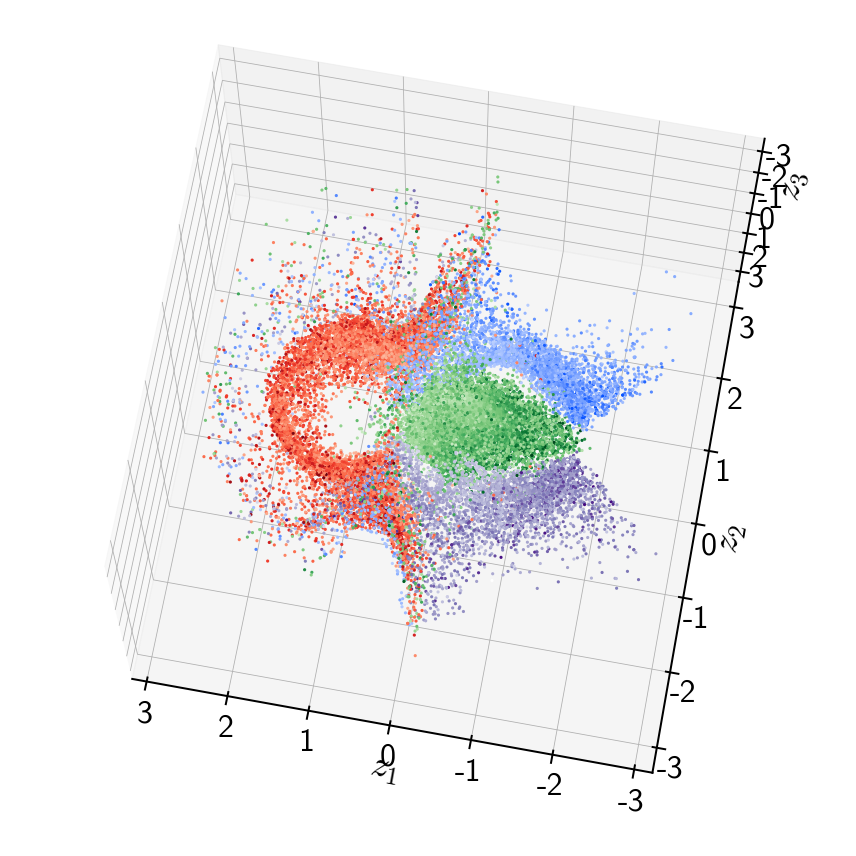

In [27]:
plt.close()
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_tick_params(width=2, length=10)
ax.yaxis.set_tick_params(width=2, length=10)
ax.zaxis.set_tick_params(width=2, length=10)

# Factors by which each energy dominates over the others
T_dom = np.minimum(T / np.abs(B), T / TK)
TK_dom = np.minimum(TK / np.abs(B), TK / T)
B_dom = np.minimum(np.abs(B) / T, np.abs(B) / TK)
sign_B = np.sign(B)

# Find which points are controlled by each energy scale
T_control = T_dom > 1
TK_control = TK_dom >= 1
posB_control = np.logical_and(B_dom > 1, sign_B == 1)
negB_control = np.logical_and(B_dom > 1, sign_B == -1)
B_control = posB_control | negB_control

# Magic in preparation for odd colormap
cs = np.empty_like(T_dom)
cs[TK_control] = np.minimum(2, np.log10(TK_dom[TK_control]))
cs[T_control] = 2 + np.minimum(2, np.log10(T_dom[T_control]))
cs[posB_control] = 4 + np.minimum(2, np.log10(B_dom[posB_control]))
cs[negB_control] = 6 + np.minimum(2, np.log10(B_dom[negB_control]))

# Stitch together a bunch of colormaps
tk_cmap = plt.cm.get_cmap('Reds')
t_cmap = plt.cm.get_cmap('Greens')
posb_cmap = plt.cm.get_cmap('Purples')
negb_cmap = colors.LinearSegmentedColormap.from_list('my_aqua', ['white', 'xkcd:electric blue'])
r_map = tk_cmap(np.arange(256))
g_map = t_cmap(np.arange(256))
p_map = posb_cmap(np.arange(256))
b_map = negb_cmap(np.arange(256))
new_arr = np.concatenate((r_map, g_map, p_map, b_map))
new_cmap = colors.ListedColormap(new_arr)

scat = plt.scatter(active1[::2], active2[::2], zs=active3[::2], c=cs[::2],
                   cmap=new_cmap, s=10, alpha=1.0, linewidths=0, vmin=0, vmax=8, rasterized=True)

ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.set_zlabel(r"$z_3$")

ax.view_init(nice_elev, nice_azim)
plt.tight_layout()
plt.show()

## Plot linear traversals along each latent dimension

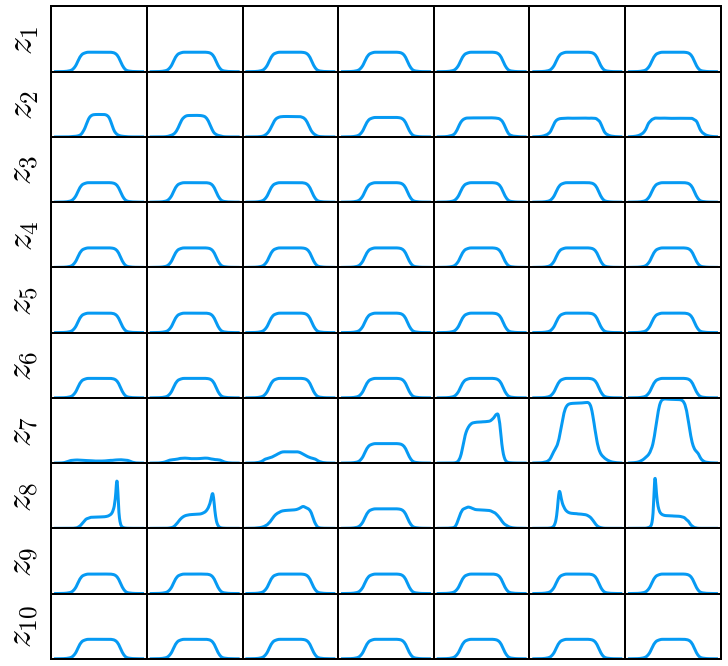

In [28]:
n_latents = 10
num_curves = 7

fig, axs = plt.subplots(n_latents, num_curves, figsize=(12, 12), gridspec_kw={'wspace': 0.0, 'hspace': 0.0})

encoder, decoder = full_model.encoder, full_model.decoder

n_latents = 10
with torch.no_grad():
    for i in range(n_latents):
        latent_pt = torch.zeros(1, n_latents)
        for j, val in enumerate(np.linspace(-2, 2, num=num_curves)):
            latent_pt[0, i] = val
            curve = torch.nn.functional.softplus(decoder(latent_pt))[0].numpy()
            axs[i, j].plot(curve, lw=3, color='xkcd:azure')
            axs[i, j].tick_params(bottom=False, top=False, labelbottom=False, left=False, labelleft=False)
            if j == 0:
                axs[i, j].set_ylabel(r"$z_{" + str(i+1) + "}$")
            axs[i, j].set_ylim(0, 1)

plt.show()

# Are these learned latent spaces "compatible" with each other?

# I.e. Smooth curve in 3-dim space $\leftrightarrow$ smooth curve in 5-dim space?

In [29]:
full_targets = np.array(t)[fullp_indices['train'], :]
lowB_targets = np.array(t)[lowB_indices['train'], :]

# Find pts that are the same between the two sets
match_idxs = np.intersect1d(fullp_indices['train'], lowB_indices['train'])

curves = np.array(t)[match_idxs, :]
curves = torch.tensor(curves, dtype=torch.float32)

In [30]:
# Shove all these points into the lowB encoder
lowB_enc = lowB_model.encoder
lowB_latent = lowB_enc(curves)[:, :10].detach().cpu().numpy()

In [31]:
# These are indices into the full dataset which form nice paths in the low-B, low-T latent space
path1 = np.array([68945, 104237, 147683, 189691, 244021, 317952, 376655, 436008, 482315, 593649, 531429, 566112, 563582])
path2 = np.array([67048, 104296, 145213, 191287, 257100, 309557, 347354, 393436, 447463, 474983, 565970, 521315, 564851])
path3 = np.array([183041, 124009, 88990, 62655, 44074, 55388, 64829, 80022, 137534, 177824, 250995])
path4 = np.array([499939, 470701, 510580, 539409, 587505, 574962, 532228, 515172, 499882, 528270])

# Find what indexs into match_idxs gives *these* indexes?
path1_pts = [np.argwhere(match_idxs == idx)[0, 0] for idx in path1]
path2_pts = [np.argwhere(match_idxs == idx)[0, 0] for idx in path2]
path3_pts = [np.argwhere(match_idxs == idx)[0, 0] for idx in path3]
path4_pts = [np.argwhere(match_idxs == idx)[0, 0] for idx in path4]

## Hand-selected paths in low-$B$, low-$T$ latent space

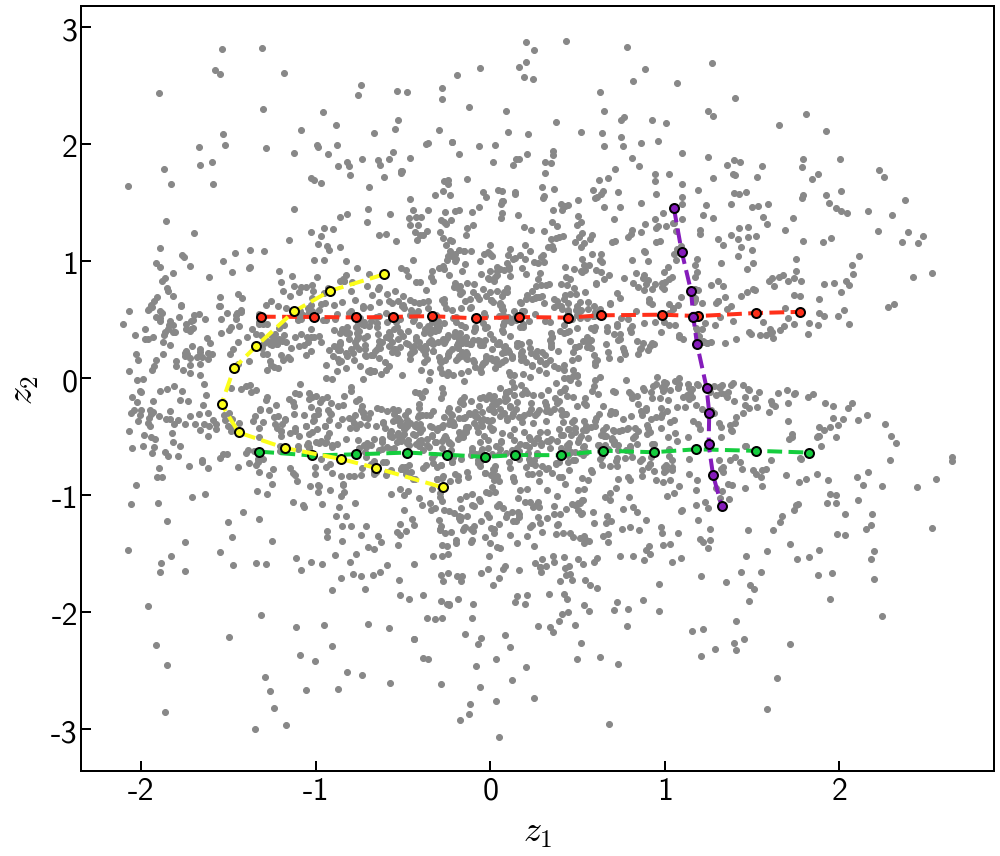

In [32]:
plt.close()
plt.figure(figsize=(14, 12))
plt.scatter(lowB_latent[:, 1], -lowB_latent[:, 5], color='#888888')
plt.plot(lowB_latent[path1_pts][:, 1], -lowB_latent[path1_pts][:, 5], 'o--',
         lw=4, markersize=9, color='#FF301A', markeredgecolor='k', mew=2)
plt.plot(lowB_latent[path2_pts][:, 1], -lowB_latent[path2_pts][:, 5], 'o--',
         lw=4, markersize=9, color='#15CD3E', markeredgecolor='k', mew=2)
plt.plot(lowB_latent[path3_pts][:, 1], -lowB_latent[path3_pts][:, 5], 'o--',
         lw=4, markersize=9, color='#FCFE1A', markeredgecolor='k', mew=2)
plt.plot(lowB_latent[path4_pts][:, 1], -lowB_latent[path4_pts][:, 5], 'o--',
         lw=4, markersize=9, color='#851CBB', markeredgecolor='k', mew=2)
plt.xlabel(r"$z_1$")
plt.ylabel(r"$z_2$")
plt.tight_layout()
plt.show()

# Same paths, but now mapped into full-param latent space


### Note: Matplotlib does not properly "depth-order" 3-dimensional plots with multiple elements. So, do not trust what is "in front of" or "behind of" other things.

In [33]:
# Shove all these points into the full-param encoder
full_enc = full_model.encoder
full_latent = full_enc(curves)[:, :10].detach().cpu().numpy()

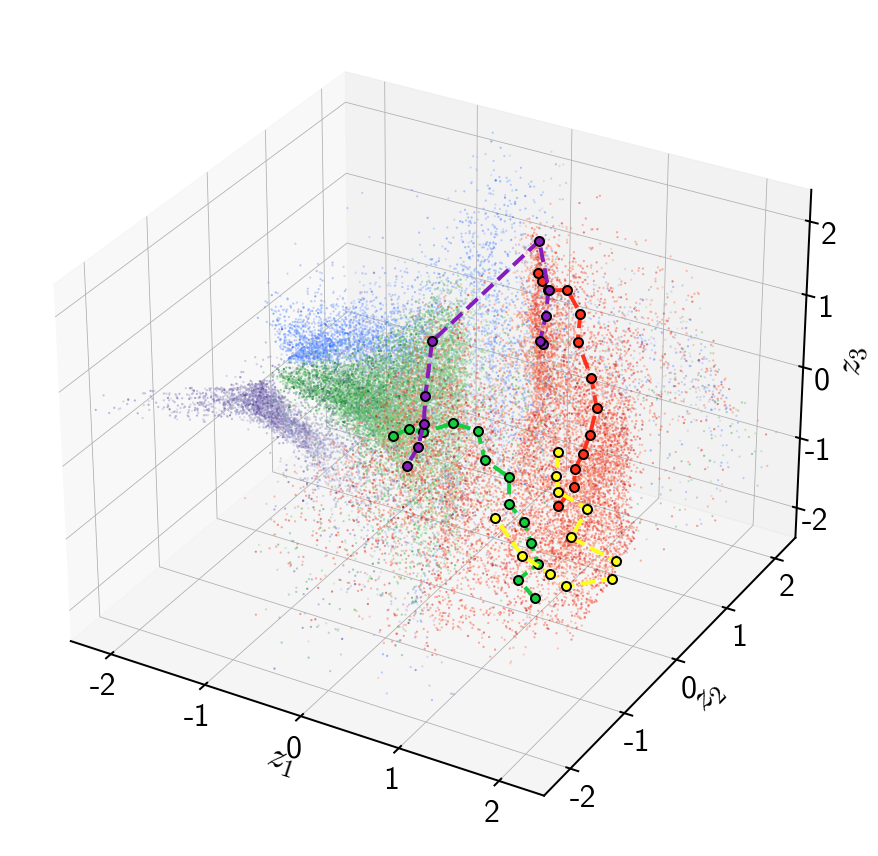

In [34]:
plt.close()
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(projection='3d')

xs, ys, zs = full_latent[:, 6], -full_latent[:, 7], full_latent[:, 1]

scat = plt.scatter(active1[::2], active2[::2], zs=active3[::2], c=cs[::2], cmap=new_cmap, s=5, alpha=0.5, linewidths=0, vmin=0, vmax=8, rasterized=True)
ax.plot(full_latent[path1_pts][:, 6], -full_latent[path1_pts][:, 7], full_latent[path1_pts][:, 1],
        'o--', color='#FF301A', lw=4, markersize=9, mew=2, markeredgecolor='k', zorder=10)
ax.plot(full_latent[path2_pts][:, 6], -full_latent[path2_pts][:, 7], full_latent[path2_pts][:, 1],
        'o--', color='#15CD3E', lw=4, markersize=9, mew=2, markeredgecolor='k', zorder=10)
ax.plot(full_latent[path3_pts][:, 6], -full_latent[path3_pts][:, 7], full_latent[path3_pts][:, 1],
        'o--', color='#FCFE1A', lw=4, markersize=9, mew=2, markeredgecolor='k', zorder=10)
ax.plot(full_latent[path4_pts][:, 6], -full_latent[path4_pts][:, 7], full_latent[path4_pts][:, 1],
        'o--', color='#851CBB', lw=4, markersize=9, mew=2, markeredgecolor='k', zorder=10)
fig.set_tight_layout(True)

ax.set_xlim(-2.335672745215704, 2.344907678821839)
ax.set_ylim(-2.375426886321407, 2.3311497351210346)
ax.set_zlim(-2.3354069331137023, 2.32858642604543)

ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.set_zlabel(r"$z_3$")
plt.show()